In [9]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from deap import base, creator, tools, algorithms
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.impute import SimpleImputer

In [2]:
# Assuming X_train, X_test, y_train, y_test are defined and available
file_path = 'ML_photocatalysis2.xlsx'

# Read the Excel file
data = pd.read_excel(file_path, header=0)

# Assuming 'df' is your pandas DataFrame.
df = data.sample(frac=1, random_state=38).reset_index(drop=True)

# Separate the features and the target variable
X = df[['Ni to TiO2 ratio', 'gC3N4 to TiO2 ratio', 'dosage', 'Time']]
y = df['SA removal rate']

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:

# Define the parameter grid to search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (50, 100, 50), (100, 50, 100)],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'max_iter': [1000, 2000, 3000],
}

# Initialize the MLPRegressor model
regr = MLPRegressor(random_state=42, max_iter=10000)
# regr = MLPRegressor(random_state=42, max_iter=10000, activation='logistic')
activation='tanh'
# Initialize the Grid Search model
grid_search = GridSearchCV(regr, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Best model
best_model_MLP = grid_search.best_estimator_

# Predictions
y_pred_test = best_model_MLP.predict(X_test_scaled)
y_pred_train = best_model_MLP.predict(X_train_scaled)

# Evaluate the model
n_test = X_test_scaled.shape[0]  # Number of observations
p_test = X_test_scaled.shape[1]  # Number of predictors
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
test_adjusted_r_squared = 1 - (1 - test_r2) * (n_test - 1) / (n_test - p_test - 1)

n_train = X_train_scaled.shape[0]  # Number of observations
p_train = X_train_scaled.shape[1]  # Number of predictors
train_mse = mean_squared_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)
train_adjusted_r_squared = 1 - (1 - train_r2) * (n_train - 1) / (n_train - p_train - 1)

print(f'Best model parameters: {grid_search.best_params_}')
print(f'MSE_test: {test_mse}, R2_test: {test_r2}, Adjust_R2_test: {test_adjusted_r_squared}')
print(f'MSE_train: {train_mse}, R2_train: {train_r2}, Adjust_R2_train: {train_adjusted_r_squared}')

# Note: BIC calculation is omitted as it requires a specific function `calculate_log_likelihood_from_mse` and `em.bic`
# which are not standard in sklearn and need to be defined.


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best model parameters: {'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01, 'max_iter': 1000, 'solver': 'adam'}
MSE_test: 0.0012766163811221791, R2_test: 0.9776072845197046, Adjust_R2_test: 0.9741622513688899
MSE_train: 0.001733954896552702, R2_train: 0.9653365043539711, Adjust_R2_train: 0.9641514275797479


In [10]:
def get_some_data():
    cols_to_use = ['Ni to TiO2 ratio', 'gC3N4 to TiO2 ratio', 'dosage', 'Time']
    my_imputer = SimpleImputer(strategy="mean")
    imputed_X = my_imputer.fit_transform(X)
    return imputed_X, y

In [17]:
# get_some_data is defined in hidden cell above.
X, y = get_some_data()
# scikit-learn originally implemented partial dependence plots only for Gradient Boosting models
# this was due to an implementation detail, and a future release will support all model types.
my_model = best_model_MLP
# fit the model as usual
my_model.fit(X, y)
# Here we make the plot
my_plots = partial_dependence(my_model,       
                                   features=[0,1,2,3], # column numbers of plots we want to show
                                   X=X,            # raw predictors data.
                                   feature_names=['Ni to TiO2 ratio', 'gC3N4 to TiO2 ratio', 'dosage', 'Time'], # labels on graphs
                                   grid_resolution=10) # number of values to plot on x axis

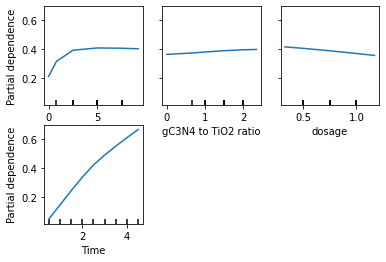

In [16]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

%matplotlib inline

# Plotting partial dependence plots
features = [0, 1, 2, 3]  # column numbers of plots we want to show
feature_names = ['Ni to TiO2 ratio', 'gC3N4 to TiO2 ratio', 'dosage', 'Time']
display = PartialDependenceDisplay.from_estimator(
    my_model,
    X,
    features=features,
    feature_names=feature_names,
    grid_resolution=10
)

# Show the plot
plt.show()
